In [19]:
from commonfunctions import *
from pre_processing import *
from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
from segmenter import Segmenter
from connected_componentes import  *
from fit import match, remove_repeated_matches, predict
from symbol import Note
from box import Box
import glob
import cv2
import pickle
from imutils import resize as im_resize
from scipy.ndimage import binary_fill_holes
from skimage.morphology import skeletonize, thin

In [20]:
quarter_templates = ['heads/black/quarter.png', 'heads/black/solid-note.png']
half_templates = ['heads/half/half-note-space.png', 'heads/half/half-space.png', 'heads/half/half.png']
whole_templates = ['heads/whole/whole-note-space.png', 'heads/whole/whole-space.png', 'heads/whole/whole.png']

templates = {
    'quarters': [cv2.imread(temp_path, 0) for temp_path in quarter_templates],
    'halfs': [cv2.imread(temp_path, 0) for temp_path in half_templates],
    'wholes': [cv2.imread(temp_path, 0) for temp_path in whole_templates]
}

In [21]:
label_map = {
    0:{
        0: 'N0'
    },
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

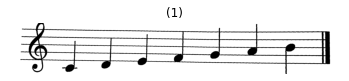

In [22]:
img = io.imread("testcases/test-set-camera-captured/test-cases/25.jpg")
img = get_gray(img)
img = get_thresholded(img, threshold_otsu(img))
horizontal = IsHorizontal(img)
if horizontal == False:
    theta = deskew(img)
    img = rotation(img,theta)
    img = get_gray(img)
    img = get_thresholded(img, threshold_otsu(img))
    img = get_closer(img)
show_images([img])

(351, 2293)


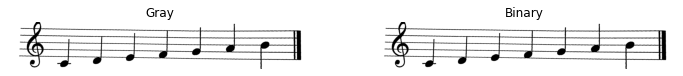

In [23]:
#img = io.imread('testcases/test-set-scanned/test-cases/02.PNG')
print(img.shape)
# if img.shape[1] < 1300:
#     img = resize(img, (img.shape[0], 2000))
# if img.shape[0] > 250:
#     img = resize(img, (250, img.shape[1]))
# print(img.shape)
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
show_images([gray, bin_img], ['Gray', 'Binary'])

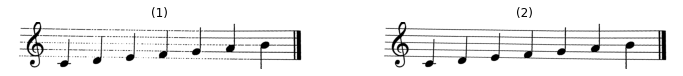

In [24]:
segmenter = Segmenter(bin_img)
imgs_with_staff = segmenter.regions_with_staff
imgs_without_staff = segmenter.regions_without_staff

for i, img in enumerate(imgs_without_staff):
    show_images([img, imgs_with_staff[i]])

43
51 47


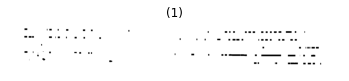

In [25]:
imgs_spacing = []
imgs_rows = []
coord_imgs = []
for i, img in enumerate(imgs_with_staff):
    spacing, rows, no_staff_img = coordinator(img,horizontal)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)
    coord_imgs.append(no_staff_img)

In [26]:
def estim(c, rows):
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0 , 0 

44
95
146
197
248
299


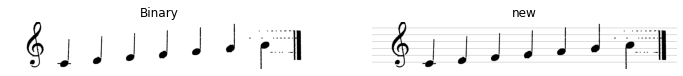

In [32]:
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        print(int(row_positions[x]))
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(coord_imgs):
    new_img = draw_staff(img,imgs_rows[i])
    # new_img = otsu(new_img)
    show_images([img,new_img], ['Binary','new'])  

In [28]:
# map_box_label = {}
# for i, img in enumerate(imgs_without_staff):
#     all_labels = []
#     detected = np.copy(255*img).astype(np.uint8)
#     for template in templates:
#         img = np.array(255*img).astype(np.uint8)
#         boxes = match(img, templates[template], 50, 400, 0.7)
#         boxes = remove_repeated_matches([j for i in boxes for j in i], 0.5)

#         box = Box(0, 0, img.shape[1], img.shape[0])
#         notes = [Note(r, "4,8, 16, 32", box, [], []) for r in boxes]
#         for idx, r in enumerate(boxes):
#             r.draw(detected, (0, 0, 255), 2)
#             line_idx, p = estim(int(r.y+r.h), imgs_rows[i])
#             print(int(r.y+r.h))
#             # print(line_idx, p)
#             label = label_map[line_idx][p]
#             map_box_label[r.x] = label
#             all_labels.append((r, label))
#             cv2.putText(detected, label, (r.x-5, r.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
#     show_images([detected])    
#     cv2.imwrite(f'detected{i}.png', detected)

#     all_labels = sorted(all_labels, key=lambda b : (b[0].x, b[0].y))
#     res = []
#     i = 0
#     while i < len(all_labels):
#         label = all_labels[i]
#         cur_res = [label[1]]
#         h = label[0].h
#         if i+1 < len(all_labels):
#             dist = np.abs(all_labels[i+1][0].y - label[0].y)
#             while i+1 < len(all_labels) and np.isclose([dist], [h], atol=7*h).any() and np.isclose([label[0].x], [all_labels[i+1][0].x], atol=1.25*label[0].w).any():
#                 cur_res.append(all_labels[i+1][1])
#                 i += 1
#                 label = all_labels[i]
#                 h = label[0].h
#                 dist = np.abs(all_labels[i+1][0].y - label[0].y)
#         i += 1
#         res.append(cur_res)
    
#     print(res)

# print(map_box_label)

In [29]:
print(imgs_rows)

[[44.5, 95.5, 146.5, 197.5, 248.5, 299.5]]


In [30]:
def get_note_name(prev, octave, duration):
    if duration in ['4', 'a_4']:
        return f'{octave[0]}{prev}{octave[1]}/4'
    elif duration in ['8', '8_b_n', '8_b_r', 'a_8']:
        return f'{octave[0]}{prev}{octave[1]}/8'
    elif duration in ['16', '16_b_n', '16_b_r', 'a_16']:
        return f'{octave[0]}{prev}{octave[1]}/16'
    elif duration in ['32', '32_b_n', '32_b_r', 'a_32']:
        return f'{octave[0]}{prev}{octave[1]}/32'
    elif duration in ['2', 'a_2']:
        return f'{octave[0]}{prev}{octave[1]}/2'
    elif duration in ['1', 'a_1']:
        return f'{octave[0]}{prev}{octave[1]}/1'

In [31]:
black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 'a_8', 'a_16', 'a_32']
ring_names = ['2', 'a_2']
whole_names = ['1', 'a_1']
clef_box = []
disk_size = segmenter.most_common / 3
for i, img in enumerate(coord_imgs):
    res = []
    prev = ''
    time_name = ''
    primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
    print(boundary)  
    for j, prim in enumerate(primitives):
        prim = binary_opening(prim)
        saved_img = (255*(1 - prim)).astype(np.uint8)
        labels = predict(saved_img)
        octave = None
        label = labels[0]
        if label in black_names:
            head_img = binary_closing(prim, disk(disk_size))
            comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
            show_images([head_img])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), imgs_rows[i])
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in ring_names:
            head_img = 1-binary_fill_holes(1-prim)
            head_img = binary_closing(head_img, disk(disk_size))
            comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), imgs_rows[i])
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in whole_names:
            c = boundary[j][2]
            line_idx, p = estim(int(c), imgs_rows[i])
            l = label_map[line_idx][p]
            print(c)
            print(l)
        elif label in ['bar', 'bar_b', 'clef', 'clef_b', 'natural', 'natural_b'] or label in []:
            continue
        elif label in ['#', '#_b']:
            prev = '#'
        elif label in ['cross']:
            prev = '##'
        elif label in ['flat', 'flat_b']:
            prev = '&'
        elif label in ['dot', 'dot_b', 'p']:
            res.append('.')
        elif label in ['t2', 't4']:
            time_name += label[1]
        elif label in ['t24', 't24_b', 't44', 't44_b']:
            time_name = label[1]+label[2]
        elif label == 'chord':
            print('Chord')
            img = thin(1-prim.copy(), max_iter=20)
            show_images([img, skeletonize(1-img)])
            head_img = binary_closing(1-img, disk(disk_size))
            show_images([head_img])

        io.imsave(f'testresult/{i}_{j}.png', saved_img)
        show_images([prim], [label])
    if len(time_name) == 2:
        res = [f'\meter<"{time_name[0]}/{time_name[1]}"">'] + res
    print(res) 

[(0, 149, 339, 276), (283, 173, 316, 209), (286, 379, 336, 481), (128, 457, 286, 469), (260, 647, 314, 709), (106, 704, 265, 716), (240, 895, 291, 958), (83, 952, 243, 963), (62, 1143, 271, 1209), (116, 1392, 247, 1458), (40, 1450, 114, 1458), (14, 1647, 226, 1714), (147, 1905, 351, 1973), (224, 2129, 230, 2150), (63, 2149, 284, 2211)]
Please wait while training the NN-HOG model....
Loading dataset. This will take time ...
Finished loading dataset.


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.